In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer

In [411]:
features = ['quality', 'year', 'remod_year', 'mas_vnr_area', 'total_basement_sqft', 'gr_living_sqft', 'baths', 'rooms_total', 'fireplaces', 'garage_sqft', 'garage_year',]
predictor = 'price'

class ModelData():
    def __init__(self):
        ## Import Raw Datasets
        self.data = pd.read_csv('./datasets/train.csv')
        self.testing_data = pd.read_csv('./datasets/test.csv')
        
        ## Clean data
        column_dict = {
                        'Id': 'id',
                        'PID': 'pid',
                        'MS SubClass': 'ms_subclass',
                        'MS Zoning': 'ms_zoning',
                        'Lot Frontage': 'frontage',
                        'Lot Area': 'lot_sqft',
                        'Street': 'street_material',
                        'Alley': 'alley',
                        'Lot Shape': 'shape',
                        'Land Contour': 'contour',
                        'Utilities': 'utilities',
                        'Lot Config': 'config',
                        'Land Slope': 'slope',
                        'Neighborhood': 'neighborhood',
                        'Condition 1': 'cond_1',
                        'Condition 2': 'cond_2',
                        'Bldg Type': 'type',
                        'House Style': 'style',
                        'Overall Qual': 'quality',
                        'Overall Cond': 'condition',
                        'Year Built': 'year',
                        'Year Remod/Add': 'remod_year',
                        'Roof Style': 'roof',
                        'Roof Matl': 'roof_mat',
                        'Exterior 1st': 'ext_1',
                        'Exterior 2nd': 'ext_2',
                        'Mas Vnr Type': 'mas_vnr_type',
                        'Mas Vnr Area': 'mas_vnr_area',
                        'Exter Qual': 'exter_qual',
                        'Exter Cond': 'exter_cond',
                        'Foundation': 'foundation',
                        'Bsmt Qual': 'basement_qual',
                        'Bsmt Cond': 'basement_cond',
                        'Bsmt Exposure': 'basement_exposure',
                        'BsmtFin Type 1': 'basement_fin_1',
                        'BsmtFin SF 1': 'basement_fin_sqft_1',
                        'BsmtFin Type 2': 'basement_fin_2',
                        'BsmtFin SF 2': 'basement_fin_sqft_2',
                        'Bsmt Unf SF': 'basement_unfin_sqft',
                        'Total Bsmt SF': 'total_basement_sqft',
                        'Heating': 'heating',
                        'Heating QC': 'heating_qc',
                        'Central Air': 'ac',
                        'Electrical': 'electrical',
                        '1st Flr SF': 'sqft_1',
                        '2nd Flr SF': 'sqft_2',
                        'Low Qual Fin SF': 'low_qual_sqft',
                        'Gr Liv Area': 'gr_living_sqft',
                        'Bsmt Full Bath': 'basement_bath',
                        'Bsmt Half Bath': 'basement_half_bath',
                        'Full Bath': 'full_bath',
                        'Half Bath': 'half_bath',
                        'Bedroom AbvGr': 'bed',
                        'Kitchen AbvGr': 'kitchen',
                        'Kitchen Qual': 'kitchen_qual',
                        'TotRms AbvGrd': 'rooms_total',
                        'Functional': 'functional',
                        'Fireplaces': 'fireplaces',
                        'Fireplace Qu': 'fireplace_qual',
                        'Garage Type': 'garage_type',
                        'Garage Yr Blt': 'garage_year',
                        'Garage Finish': 'garage_finish',
                        'Garage Cars': 'garage_size',
                        'Garage Area': 'garage_sqft',
                        'Garage Qual': 'garage_qual',
                        'Garage Cond': 'garage_cond',
                        'Paved Drive': 'paved_drive',
                        'Wood Deck SF': 'deck_wood_sqft',
                        'Open Porch SF': 'porch_sqft',
                        'Enclosed Porch': 'porch_enc_sqft',
                        '3Ssn Porch': 'porch_3_ssn',
                        'Screen Porch': 'porch_screened',
                        'Pool Area': 'pool_sqft',
                        'Pool QC': 'pool_qc',
                        'Fence': 'fence',
                        'Misc Feature': 'misc',
                        'Misc Val': 'misc_sqft',
                        'Mo Sold': 'sold_month',
                        'Yr Sold': 'sold_year',
                        'Sale Type': 'sale_type',
                        'SalePrice': 'price'
                    }
        self.data.rename(columns=column_dict, inplace=True)
        self.testing_data.rename(columns=column_dict, inplace=True)
        
        ##############################################################
        # Data cleaning

        # Fill NaNs
        # Impute missing data by property type
        for c in ['frontage']:
        # sets index to type, makes a dict of median values of target var based on group by category, then applies that grouped median to null values of target var and saves in place
            self.data[c] = self.data.set_index(['type'])[c].fillna(self.data[['type', c]].groupby(['type']).median().to_dict()[c]).reset_index()[c]
            self.testing_data[c] = self.data.set_index(['type'])[c].fillna(self.data[['type', c]].groupby(['type']).median().to_dict()[c]).reset_index()[c]

        # Fill Missing Data
        # Categorical
        for c in ['mas_vnr_type', 'alley']:
            self.data[c].fillna('None', inplace=True)
            self.testing_data[c].fillna('None', inplace=True)

        # Numeric
        for c in ['mas_vnr_area', 'basement_fin_sqft_1', 'basement_fin_sqft_2', 'basement_unfin_sqft', 'total_basement_sqft', 'basement_bath', 'basement_half_bath',
                  'garage_size', 'garage_sqft']:
            self.data[c].fillna(0, inplace=True)
            self.testing_data[c].fillna(0, inplace=True)


        # garage_year
        self.data['garage_year'].fillna(self.data[self.data['garage_year'].notna()]['garage_year'].min(), inplace=True)
        self.testing_data['garage_year'].fillna(self.data[self.data['garage_year'].notna()]['garage_year'].min(), inplace=True)
        self.data.at[1699,'garage_year'] = 2006 # incorrect data, changing to year property was built
        # misc
        self.data.drop(columns=['misc'], inplace=True)
        self.testing_data.drop(columns=['misc'], inplace=True)
        # utilities
        self.data.drop(columns=['utilities'], inplace=True)
        self.testing_data.drop(columns=['utilities'], inplace=True)
        # roof_mat
        self.data.drop(columns=['roof_mat'], inplace=True)
        self.testing_data.drop(columns=['roof_mat'], inplace=True)
        # ext 1 & 2
        self.data.drop(columns=['ext_1', 'ext_2'], inplace=True)
        self.testing_data.drop(columns=['ext_1', 'ext_2'], inplace=True)

        # Ordinal Encoding
        enc = OrdinalEncoder(categories=[[np.NaN, 'Po', 'Fa', 'TA', 'Gd', 'Ex']])
        for c in ['basement_qual', 'basement_cond', 'heating_qc', 'kitchen_qual', 'fireplace_qual', 'garage_qual', 'garage_cond', 'pool_qc', 'exter_qual', 'exter_cond']:
            self.data[[c]] = enc.fit_transform(self.data[[c]])
            self.data[c].fillna(0, inplace=True)

            self.testing_data[[c]] = enc.fit_transform(self.testing_data[[c]])
            self.testing_data[c].fillna(0, inplace=True)
        
        self.data['basement_exposure'] = self.data['basement_exposure'].map({'Gd':4, 'Av':3, 'Mn': 2, 'No':1, np.NaN:0})
        self.testing_data['basement_exposure'] = self.testing_data['basement_exposure'].map({'Gd':4, 'Av':3, 'Mn': 2, 'No':1, np.NaN:0})

        self.data['basement_fin_1'] = self.data['basement_fin_1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.NaN:0})
        self.testing_data['basement_fin_1'] = self.testing_data['basement_fin_1'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.NaN:0})
        
        self.data['basement_fin_2'] = self.data['basement_fin_2'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.NaN:0})
        self.testing_data['basement_fin_2'] = self.testing_data['basement_fin_2'].map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, np.NaN:0})

        self.data['garage_finish'] = self.data['garage_finish'].map({np.NaN:0, 'NA':0, 'Unf':1, 'RFn':2, 'Fin':3})
        self.testing_data['garage_finish'] = self.testing_data['garage_finish'].map({np.NaN:0, 'NA':0, 'Unf':1, 'RFn':2, 'Fin':3})

        self.data['fence'] = self.data['fence'].map({'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0, np.NaN:0})
        self.testing_data['fence'] = self.testing_data['fence'].map({'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0, np.NaN:0})

        self.data['electrical'] = self.data['electrical'].map({np.NaN:0, 'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5})
        self.testing_data['electrical'] = self.testing_data['electrical'].map({np.NaN:0, 'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5})

        self.data['shape'] = self.data['shape'].map({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3, np.NaN:0})
        self.testing_data['shape'] = self.testing_data['shape'].map({'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3, np.NaN:0})

        self.data['slope'] = self.data['slope'].map({'Sev':0, 'Mod':1, 'Gtl':2, np.NaN:1})
        self.testing_data['slope'] = self.testing_data['slope'].map({'Sev':0, 'Mod':1, 'Gtl':2, np.NaN:1})

        self.data['cond_1'] = self.data['cond_1'].map({'Norm':1, 'Feedr':1, 'Artery':2, 'RRAn':3, 'PosN':0, 'RRAe':3, 'PosA':0, 'RRNn':3, 'RRNe':3})
        self.data['cond_2'] = self.data['cond_2'].map({'Norm':1, 'Feedr':1, 'Artery':2, 'RRAn':3, 'PosN':0, 'RRAe':3, 'PosA':0, 'RRNn':3, 'RRNe':3})
        self.data['conds'] = self.data[['cond_1', 'cond_2']].max(axis=1)
        self.data.drop(['cond_1', 'cond_2'], axis=1, inplace=True)
        self.testing_data['cond_1'] = self.testing_data['cond_1'].map({'Norm':1, 'Feedr':1, 'Artery':2, 'RRAn':3, 'PosN':0, 'RRAe':3, 'PosA':0, 'RRNn':3, 'RRNe':3})
        self.testing_data['cond_2'] = self.testing_data['cond_2'].map({'Norm':1, 'Feedr':1, 'Artery':2, 'RRAn':3, 'PosN':0, 'RRAe':3, 'PosA':0, 'RRNn':3, 'RRNe':3})
        self.testing_data['conds'] = self.testing_data[['cond_1', 'cond_2']].max(axis=1)
        self.testing_data.drop(['cond_1', 'cond_2'], axis=1, inplace=True)

        self.data['style'] = self.data['style'].map({'1.5Fin': 1, '1.5Unf': 1, '1Story': 1, '2.5Fin':2, '2.5Unf':2, '2Story':2, 'SFoyer':1, 'SLvl':1})
        self.testing_data['style'] = self.testing_data['style'].map({'1.5Fin': 1, '1.5Unf': 1, '1Story': 1, '2.5Fin':2, '2.5Unf':2, '2Story':2, 'SFoyer':1, 'SLvl':1})

        self.data['foundation'] = self.data['foundation'].map({'Slab':0, 'Stone':1, 'BrkTil':2, 'CBlock':3, 'PConc':4, 'Wood':5})
        self.testing_data['foundation'] = self.testing_data['foundation'].map({'Slab':0, 'Stone':1, 'BrkTil':2, 'CBlock':3, 'PConc':4, 'Wood':5})

        self.data['heating'] = self.data['heating'].map({'GasW':1, 'Grav':0, 'OthW':0, 'Wall':0, 'Floor':0, 'GasA':2})
        self.testing_data['heating'] = self.testing_data['heating'].map({'GasW':1, 'Grav':0, 'OthW':0, 'Wall':0, 'Floor':0, 'GasA':2})

        self.data['functional'] = self.data['functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
        self.testing_data['functional'] = self.testing_data['functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})

        self.data['sale_type'] = self.data['sale_type'].map({'COD':0, 'ConLw':1, 'ConLd':1, 'Oth':2, 'WD':2, 'ConLI':3, 'CWD':3, 'New':4, 'Con':5, 'VWD':2})
        self.testing_data['sale_type'] = self.testing_data['sale_type'].map({'COD':0, 'ConLw':1, 'ConLd':1, 'Oth':2, 'WD':2, 'ConLI':3, 'CWD':3, 'New':4, 'Con':5, 'VWD':2})

        # Categorical Encoding
        # garage_type
        self.data['garage_type'] = self.data['garage_type'].map({np.NaN:0, 'Attchd':1, 'Detchd':2, 'BuiltIn':3, 'Basment':4, '2Types':5, 'CarPort':6})
        self.testing_data['garage_type'] = self.testing_data['garage_type'].map({np.NaN:0, 'Attchd':1, 'Detchd':2, 'BuiltIn':3, 'Basment':4, '2Types':5, 'CarPort':6})

        ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
        enc = pd.DataFrame(ohe.fit_transform(self.data[['garage_type']]), columns=['gar_attached', 'gar_detached', 'gar_builtin', 'gar_basement', 'gar_2types', 'gar_carport'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['garage_type'], inplace=True, axis=1)
        
        enc = pd.DataFrame(ohe.transform(self.testing_data[['garage_type']]), columns=['gar_attached', 'gar_detached', 'gar_builtin', 'gar_basement', 'gar_2types', 'gar_carport'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['garage_type'], inplace=True, axis=1)    

        # zoning
        self.data['ms_zoning'] = self.data['ms_zoning'].map({'C (all)': 'C', 'I (all)': 'C', 'A (agr)': 'C', 'RL': 'RL', 'RM': 'RM', 'FV': 'FV', 'RH': 'RH'})
        self.testing_data['ms_zoning'] = self.testing_data['ms_zoning'].map({'C (all)': 'C', 'I (all)': 'C', 'A (agr)': 'C', 'RL': 'RL', 'RM': 'RM', 'FV': 'FV', 'RH': 'RH'})

        ohe = OneHotEncoder(categories=[['C', 'RH', 'FV', 'RM', 'RL']], handle_unknown='ignore', drop='first', sparse=False)    
        enc = pd.DataFrame(ohe.fit_transform(self.data[['ms_zoning']]), columns=['zone_res_hi', 'zone_res_vil', 'zone_res_med', 'zone_res_low'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['ms_zoning'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['ms_zoning']]), columns=['zone_res_hi', 'zone_res_vil', 'zone_res_med', 'zone_res_low'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['ms_zoning'], inplace=True, axis=1)

        # alley
        ohe = OneHotEncoder(categories=[['None', 'Grvl', 'Pave']], handle_unknown='ignore', drop='first', sparse=False)    
        enc = pd.DataFrame(ohe.fit_transform(self.data[['alley']]), columns=['alley_gravel', 'alley_pave'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['alley'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['alley']]), columns=['alley_gravel', 'alley_pave'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['alley'], inplace=True, axis=1)

        # contour
        ohe = OneHotEncoder(categories=[['Low', 'HLS', 'Bnk', 'Lvl']], handle_unknown='ignore', drop='first', sparse=False)    
        enc = pd.DataFrame(ohe.fit_transform(self.data[['contour']]), columns=['contour_hill', 'contour_bank', 'contour_level'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['contour'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['contour']]), columns=['contour_hill', 'contour_bank', 'contour_level'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['contour'], inplace=True, axis=1)

        # config
        ohe = OneHotEncoder(categories=[['FR3', 'FR2', 'CulDSac', 'Corner', 'Inside']], handle_unknown='ignore', drop='first', sparse=False)    
        enc = pd.DataFrame(ohe.fit_transform(self.data[['config']]), columns=['config_fr_2', 'config_culd', 'config_corner', 'config_inside'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['config'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['config']]), columns=['config_fr_2', 'config_culd', 'config_corner', 'config_inside'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['config'], inplace=True, axis=1)

        # neighborhood
        neighbs = ['Landmrk', 'GrnHill', 'Greens', 'Blueste', 'NPkVill', 'Veenker', 'BrDale', 'Blmngtn', 'MeadowV', 'ClearCr', 'SWISU', 'StoneBr', 'Timber', 'NoRidge', 'IDOTRR', 'Crawfor','BrkSide', 'Mitchel', 'SawyerW', 'NWAmes', 'Sawyer', 'Gilbert', 'NridgHt', 'Somerst', 'Edwards', 'OldTown', 'CollgCr', 'NAmes']
        neighbs_cols = ['n_grnhill', 'n_greens', 'n_blueste', 'n_npkvill', 'n_veenker', 'n_brdale', 'n_blmngtn', 'n_meadowv', 'n_clearcr', 'n_swisu', 'n_stonebr', 'n_timber', 'n_noridge', 'n_idotrr', 'n_crawfor','n_brkside', 'n_mitchel', 'n_sawyerw', 'n_nwames', 'n_sawyer', 'n_gilbert', 'n_nridght', 'n_somerst', 'n_edwards', 'n_oldtown', 'n_collgcr', 'n_names']

        ohe = OneHotEncoder(categories=[neighbs], handle_unknown='ignore', drop='first', sparse=False)    
        enc = pd.DataFrame(ohe.fit_transform(self.data[['neighborhood']]), columns=neighbs_cols, index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['neighborhood'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['neighborhood']]), columns=neighbs_cols, index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['neighborhood'], inplace=True, axis=1)

        # # type
        self.data['type'].replace('2fmCon', 'Duplex', inplace=True)
        self.testing_data['type'].replace('2fmCon', 'Duplex', inplace=True)

        ohe = OneHotEncoder(categories=[['Duplex', 'Twnhs', '1Fam', 'TwnhsE']], handle_unknown='ignore', drop='first', sparse=False)    
        enc = pd.DataFrame(ohe.fit_transform(self.data[['type']]), columns=['type_twn', 'type_sf', 'type_twn_end'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['type'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['type']]), columns=['type_twn', 'type_sf', 'type_twn_end'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['type'], inplace=True, axis=1)

        # roof
        self.data['roof'] = self.data['roof'].map({'Gable':'Gable', 'Hip':'Hip', 'Flat':'Unc', 'Gambrel':'Unc', 'Mansard':'Unc', 'Shed':'Unc'})
        self.testing_data['roof'] = self.testing_data['roof'].map({'Gable':'Gable', 'Hip':'Hip', 'Flat':'Unc', 'Gambrel':'Unc', 'Mansard':'Unc', 'Shed':'Unc'})

        ohe = OneHotEncoder(categories=[['Unc', 'Hip', 'Gable']], handle_unknown='ignore', drop='first', sparse=False)
        enc = pd.DataFrame(ohe.fit_transform(self.data[['roof']]), columns=['roof_hip', 'roof_gable'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['roof'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['roof']]), columns=['roof_hip', 'roof_gable'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['roof'], inplace=True, axis=1)

        ohe = OneHotEncoder(categories=[['None', 'CBlock', 'BrkCmn', 'BrkFace', 'Stone']], handle_unknown='ignore', drop='first', sparse=False)
        enc = pd.DataFrame(ohe.fit_transform(self.data[['mas_vnr_type']]), columns=['vaneer_brk_c', 'vaneer_cb', 'vaneer_brk_face', 'vaneer_stone'], index=self.data.index)
        self.data = self.data.join(enc)
        self.data.drop(['mas_vnr_type'], inplace=True, axis=1)
        enc = pd.DataFrame(ohe.transform(self.testing_data[['mas_vnr_type']]), columns=['vaneer_brk_c', 'vaneer_cb', 'vaneer_brk_face', 'vaneer_stone'], index=self.testing_data.index)
        self.testing_data = self.testing_data.join(enc)
        self.testing_data.drop(['mas_vnr_type'], inplace=True, axis=1)

        # Binary Encoding
        # street_material
        self.data['street_material'] = self.data['street_material'].map({'Grvl':0, 'Pave':1, np.NaN:0})
        self.testing_data['street_material'] = self.testing_data['street_material'].map({'Grvl':0, 'Pave':1, np.NaN:0})   

        self.data['ac'] = self.data['ac'].map({'N':0, 'Y':1, np.NaN:0})
        self.testing_data['ac'] = self.testing_data['ac'].map({'N':0, 'Y':1, np.NaN:0})


    
        ##############################################################
        ## Feature Creations
        # log price
        self.data['price_log'] = np.log(self.data['price']) 
        # price/sqft
        self.data['p_sqft'] = self.data['price'] / self.data['gr_living_sqft']
        # sold month
        self.data['sold_year_mo'] = round(self.data['sold_year'] + self.data['sold_month'] / 12, 2)
        self.testing_data['sold_year_mo'] = round(self.testing_data['sold_year'] + self.testing_data['sold_month'] / 12, 2)
        # baths
        self.data['baths'] = self.data['full_bath'] + self.data['half_bath']
        self.testing_data['baths'] = self.testing_data['full_bath'] + self.testing_data['half_bath']

        # storage:
        # neighb_groups = {
        #     80: ['IDOTRR'],
        #     90: ['OldTown', 'SWISU', 'MeadowV', 'BrDale'],
        #     100: ['Edwards', 'Landmrk', 'BrkSide'],
        #     110: ['NWAmes', 'NPkVill', 'NAmes', 'SawyerW', 'Gilbert'],
        #     120: ['Blueste', 'Crawfor', 'Sawyer', 'ClearCr', 'Mitchel', 'NoRidge'],
        #     130: ['CollgCr'],
        #     140: ['Blmngtn', 'Somerst', 'Timber', 'Veenker'],
        #     150: ['Greens'],
        #     160: ['StoneBr', 'NridgHt'],
        #     190: ['GrnHill']
        # }

        ##############################################################
        ## Model Export Inits
        # TTS
        self.X_train = None
        self.X_train_active = None
        self.X_test = None
        self.X_test_active = None
        self.y_train = None
        self.y_train_active = None
        self.y_test = None
        self.y_test_active = None

        # Scaler
        self.X_train_scaled = None
        self.X_test_scaled = None

        # Preds
        self.preds = None

        # Scores
        self.lasso_train_score = None
        self.lasso_test_score = None
        self.lasso_train_rmse = None
        self.lasso_test_rmse = None

        ## Models
        self.lasso = 0

        # Feature Storage
        self.features = []
        ##############################################################

    ##############################################################
    # Plots
    def heatmap(self, cols=features, annot=True, figsize=(15, 12), cmap='coolwarm'):
        
        plt.figure(figsize=figsize)
        sns.heatmap(self.data[cols].corr(), annot=annot, cmap=cmap)
        sns.despine()
        plt.tight_layout()
        plt.show()


    def histogram(self, cols=features, figsize=(10,8), all=False, bins=10):
        if all:
            for c in self.data.columns:
                plt.figure(figsize=figsize)
                self.data[c].hist(bins=bins)
                sns.despine()
                plt.tight_layout()
                plt.show()
                if pd.api.types.is_numeric_dtype(self.data[c]):
                    print(self.data[c].skew())
        else:
            for c in cols:
                plt.figure(figsize=figsize)
                self.data[c].hist(bins=bins)
                plt.xlabel(c)
                sns.despine()
                plt.tight_layout()
                plt.show()
                if pd.api.types.is_numeric_dtype(self.data[c]):
                    print(self.data[c].skew())

    ##############################################################
    # Transformers
    def Scaler(self, train=True, test=True):
        print('Standard scaler instantiated')
        self.scaler = StandardScaler()

        # fit transformer
        if train:
            self.X_train_scaled = self.scaler.fit_transform(self.X_train_active)
        if test:
            self.X_test_scaled = self.scaler.transform(self.X_test_active)

        # update active data
        self.X_train_active = pd.DataFrame(self.X_train_scaled, columns=self.X_train_active.columns, index=self.X_train_active.index)
        self.X_test_active = pd.DataFrame(self.X_test_scaled, columns=self.X_test_active.columns, index=self.X_test_active.index)


    def Poly(self, exp=2):
        print('Poly features instantiated')
        self.poly = PolynomialFeatures(exp, include_bias=False)

        # fit transformer
        self.X_train_poly = self.poly.fit_transform(self.X_train_active)
        self.X_test_poly = self.poly.transform(self.X_test_active)

        # update active data
        self.X_train_active = pd.DataFrame(self.X_train_poly, columns=self.poly.get_feature_names_out(), index=self.X_train_active.index)
        self.X_test_active = pd.DataFrame(self.X_test_poly, columns=self.poly.get_feature_names_out(), index=self.X_test_active.index)

    def train_test(self, X, y, state=110, size=.25):
        
        print(self.data[X].isna().sum())
        
        # save original
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data[X], self.data[y], random_state=state, train_size=size)
        
        # update active data
        self.X_train_active = self.X_train
        self.X_test_active = self.X_test
        self.y_train_active = self.y_train
        self.y_test_active = self.y_test
        print('Data ready for modeling')


    ##############################################################
    # Models
    def Lasso(self, a=1.0):
        print('Lasso model instantiated')
        self.lasso = Lasso(a)


    def run_lasso(self, scale=False, poly=False, a=1.0):

        if self.lasso == 0:
            print('No Lasso model found, building')
            self.Lasso(a=a)

        print(f'Running lasso model on {features} \nAlpha of {a} applied.')

        if scale:
            print('Scaling data')
            self.Scaler()

        if poly:
            print('Adding Polynomial variables')
            self.Poly()


        # train model
        self.lasso.fit(self.X_train_active, self.y_train_active)
        # save predictions
        self.preds = pd.DataFrame(self.lasso.predict(self.X_test_active), columns=['preds'], index=self.X_test_active.index)

        # score model
        #R2
        self.lasso_train_score = self.lasso.score(self.X_train_active, self.y_train_active)
        self.lasso_test_score = self.lasso.score(self.X_test_active, self.y_test_active)
        # RMSE
        self.lasso_train_rmse = mean_squared_error(self.y_train_active, self.lasso.predict(self.X_train_active), squared=False)
        self.lasso_test_rmse = mean_squared_error(self.y_test_active, self.preds, squared=False)

        # print scores
        print(f'Train R2: {self.lasso_train_score}')
        print(f'Test R2: {self.lasso_test_score}')

        print(f'Train RMSE: {self.lasso_train_rmse}')
        print(f'Test RMSE: {self.lasso_test_rmse}')



In [412]:
test = ModelData()

In [413]:
data_local = test.data
data_testing = test.testing_data

In [420]:
data_local.iloc[:,120:130].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vaneer_stone  2051 non-null   float64
 1   price_log     2051 non-null   float64
 2   p_sqft        2051 non-null   float64
 3   sold_year_mo  2051 non-null   float64
 4   baths         2051 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 80.2 KB


In [410]:
data_local[['sale_type', 'p_sqft']].groupby(['sale_type']).mean().sort_values(by=['p_sqft'])

,p_sqft
sale_type,
COD,99.778025
ConLw,103.718103
ConLD,106.741984
Oth,118.974183
WD,119.407547
ConLI,122.154354
CWD,122.831758
New,156.661376
Con,167.093081


In [ ]:
data_local['sale_type'] = data_local['sale_type'].map({'COD':0, 'ConLw':1, 'ConLd':1, 'Oth':2, 'WD':2, 'ConLI':3, 'CWD':3, 'New':4, 'Con':5, 'VWD':2})


In [408]:
data_testing['sale_type'].value_counts()

WD       755
New       78
COD       24
ConLD      9
Oth        3
ConLw      3
CWD        2
ConLI      2
Con        1
VWD        1
Name: sale_type, dtype: int64

In [ ]:
data_local['foundation'] = data_local['foundation'].map({'Slab':0, 'Stone':1, 'BrkTil':2, 'CBlock':3, 'PConc':4, 'Wood':5})


sale_type
COD      [[AxesSubplot(0.125,0.125;0.775x0.755)]]
CWD      [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Con      [[AxesSubplot(0.125,0.125;0.775x0.755)]]
ConLD    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
ConLI    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
ConLw    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
New      [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Oth      [[AxesSubplot(0.125,0.125;0.775x0.755)]]
WD       [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

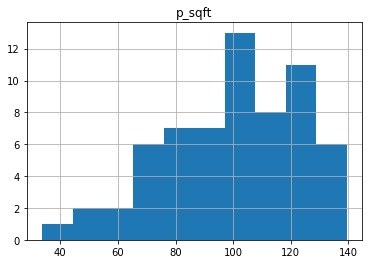

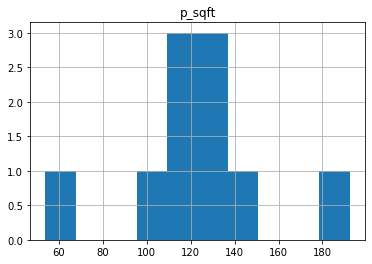

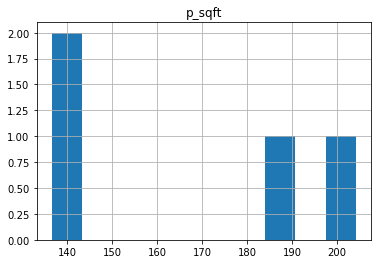

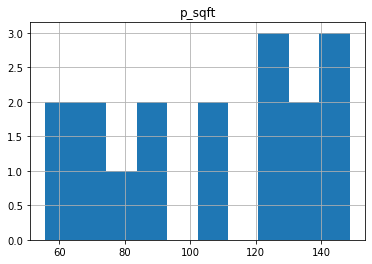

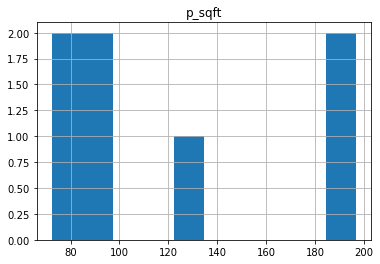

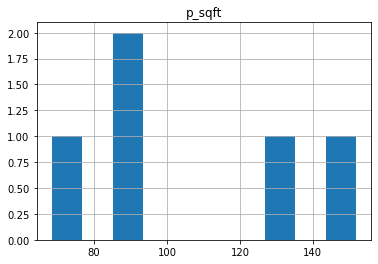

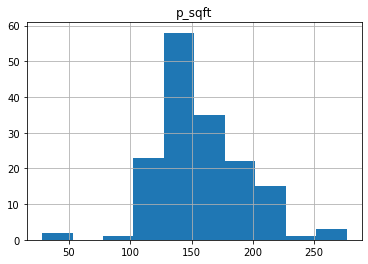

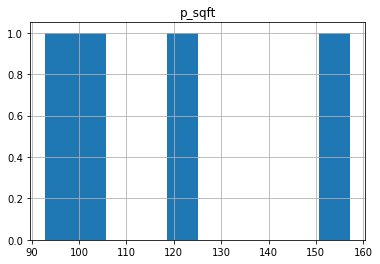

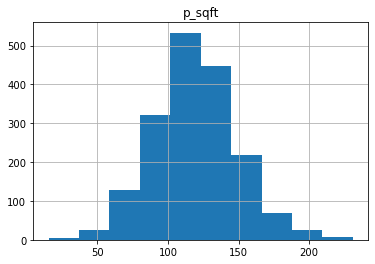

In [409]:
data_local[['sale_type', 'p_sqft']].groupby(['sale_type']).hist()

In [368]:
data_testing['exter_qual'].value_counts()

TA    552
Gd    292
Ex     25
Fa      9
Name: exter_qual, dtype: int64

In [ ]:
data_testing[['exter_qual', 'p_sqft']].groupby(['exter_qual']).value_counts()

In [327]:
# data_local['type'] = data_local['type'].map({'1Fam': '1Fam', 'TwnhsE':'TwnhsE', 'Duplex':'Duplex', 'Twnhs':'Twnhs', '2fmCon': 'Duplex'})
ohe = OneHotEncoder(categories=[['None', 'BrkCmn', 'BrkFace', 'Stone']], handle_unknown='ignore', drop='first', sparse=False)
enc = pd.DataFrame(ohe.fit_transform(data_local[['mas_vnr_type']]), columns=['vaneer_brk_c', 'vaneer_brk_face', 'vaneer_stone'], index=data_local.index)
data_local = data_local.join(enc)
data_local.drop(['mas_vnr_type'], inplace=True, axis=1)
data_local.iloc[:,-15:]
# enc = pd.DataFrame(ohe.transform(self.testing_data[['alley']]), columns=['zone_res_hi', 'zone_res_vil', 'zone_res_med', 'zone_res_low'], index=self.testing_data.index)
# self.testing_data = self.testing_data.join(enc)
# self.testing_data.drop(['alley'], inplace=True, axis=1)

# Gable    1619
# Hip       397
# Unc        35

,n_nridght,n_somerst,n_edwards,n_oldtown,n_collgcr,n_names,type_twn,type_sf,type_twn_end,price_log,p_sqft,sold_year_mo,baths,roof_hip,roof_gable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.779129,88.235294,2010.25,3,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.301383,103.675778,2009.33,3,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,11.599103,103.122044,2010.08,1,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.066811,120.498615,2010.33,3,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.838626,95.847751,2010.25,2,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.607366,172.888310,2008.08,2,0.0,1.0
2047,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.320554,95.818815,2009.25,1,0.0,1.0
2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.083905,92.524830,2009.25,2,0.0,1.0
2049,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,11.877569,120.000000,2009.92,1,0.0,1.0


In [266]:
data_local['type'].value_counts()

1Fam      1700
TwnhsE     161
Duplex     121
Twnhs       69
Name: type, dtype: int64

In [265]:
data_local[['type', 'p_sqft']].groupby('type').mean()

,p_sqft
type,
1Fam,122.385711
Duplex,90.594741
Twnhs,108.843469
TwnhsE,143.165687


In [214]:
data_local['type'] = data_local['type'].replace('2fmCon', 'Duplex')
data_local['cond_2'] = data_local['cond_2'].map({'Norm':1, 'Feedr':1, 'Artery':2, 'RRAn':3, 'PosN':0, 'RRAe':3, 'PosA':0, 'RRNn':3, 'RRNe':3})
data_local['conds'] = data_local[['cond_1', 'cond_2']].max(axis=1)

In [167]:
data_local['slope'].isna().sum()

0

In [168]:
data_testing['slope'].isna().sum()

0

In [139]:
data_local['shape'].value_counts()

3    1295
2     692
1      55
0       9
Name: shape, dtype: int64

In [29]:
data_testing['ms_zoning'].value_counts()

RL    674
RM    146
FV     38
RH     13
C       7
Name: ms_zoning, dtype: int64

In [30]:
data_local['ms_zoning'].value_counts()

RL    1598
RM     316
FV     101
C       22
RH      14
Name: ms_zoning, dtype: int64

In [24]:
data_local['ms_zoning'].map({'C (all)': 'C', 'I (all)': 'C', 'A (agr)': 'C', 'RL': 'RL', 'RM': 'RM', 'FV': 'FV', 'RH': 'RH'})
data_testing['ms_zoning'].map({'C (all)': 'C', 'I (all)': 'C', 'A (agr)': 'C', 'RL': 'RL', 'RM': 'RM', 'FV': 'FV', 'RH': 'RH'})

0      RM
1      RL
2      RL
3      RM
4      RL
       ..
873    RL
874    RL
875    RL
876    RL
877    RL
Name: ms_zoning, Length: 878, dtype: object

In [512]:
data_local['electrical'] = data_local['electrical'].map({np.NaN:0, 'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5})
data_testing['electrical'] = data_testing['electrical'].map({np.NaN:0, 'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5})

ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
ohe.fit(np.array(pd.concat([data_local['electrical'], data_testing['electrical']]).map({np.NaN:0, 'Mix':1, 'FuseP':2, 'FuseF':3, 'FuseA':4, 'SBrkr':5})).reshape(-1,1))

pd.DataFrame(ohe.transform(data_local[['electrical']]), columns=['elec_mix', 'elec_fuse_p', 'elec_fuse_f', 'elec_fuse_a', 'elec_s_braker'], index=data_local.index)
pd.DataFrame(ohe.transform(data_local[['electrical']]), columns=['elec_mix', 'elec_fuse_p', 'elec_fuse_f', 'elec_fuse_a', 'elec_s_braker'], index=data_local.index)

# enc = pd.DataFrame(ohe.transform(data_local[['electrical']]), columns=['elec_mix', 'elec_fuse_p', 'elec_fuse_f', 'elec_fuse_a', 'elec_s_braker'], index=data_local.index)
# data_local = data_local.join(enc)
# enc = pd.DataFrame(ohe.transform(data_testing[['electrical']]), columns=['elec_mix', 'elec_fuse_p', 'elec_fuse_f', 'elec_fuse_a', 'elec_s_braker'], index=data_testing.index)
# data_testing_data = data_testing.join(enc)

/Users/genebob/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/Users/genebob/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


ValueError: Shape of passed values is (2051, 0), indices imply (2051, 5)

In [443]:
data_testing[data_testing['ms_zoning'] == 'I (all)'][['bed', 'baths', 'gr_living_sqft']]

,bed,baths,gr_living_sqft
522,4,2,1836


In [450]:
data_local['electrical'].fillna('SBrkr', inplace=True)

SBrkr    1868
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64

In [433]:
data_local['ms_zoning'].value_counts()
# data_local['fence'].map({'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NA':0, np.NaN:0})

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

In [ ]:
data_local[data_local['ms_zoning']]

In [276]:
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
enc = pd.DataFrame(ohe.fit_transform(data_local[['garage_type']]), columns=['gar_attached', 'gar_detached', 'gar_builtin', 'gar_basement', 'gar_2types', 'gar_carport'], index=data_local.index)
data_local = data_local.join(enc)
data_local.head()

,id,pid,ms_subclass,ms_zoning,frontage,lot_sqft,street_material,alley,shape,contour,...,price,price_log,sold_year_mo,baths,gar_attached,gar_detached,gar_builtin,gar_basement,gar_2types,gar_carport
0,109,533352170,60,RL,70.0,13517,Pave,None,IR1,Lvl,...,130500,11.779129,2010.25,3,1.0,0.0,0.0,0.0,0.0,0.0
1,544,531379050,60,RL,43.0,11492,Pave,None,IR1,Lvl,...,220000,12.301383,2009.33,3,1.0,0.0,0.0,0.0,0.0,0.0
2,153,535304180,20,RL,68.0,7922,Pave,None,Reg,Lvl,...,109000,11.599103,2010.08,1,0.0,1.0,0.0,0.0,0.0,0.0
3,318,916386060,60,RL,73.0,9802,Pave,None,Reg,Lvl,...,174000,12.066811,2010.33,3,0.0,0.0,1.0,0.0,0.0,0.0
4,255,906425045,50,RL,82.0,14235,Pave,None,IR1,Lvl,...,138500,11.838626,2010.25,2,0.0,1.0,0.0,0.0,0.0,0.0


In [85]:
imputer_scaler = StandardScaler()
knn_imputer = KNNImputer(n_neighbors=10)

# knn_imputer.fit_transform(imputer_scaler.fit_transform(data_local[['frontage']]))
# data_local['frontage_imputed'] = 

pd.DataFrame(imputer_scaler.inverse_transform(knn_imputer.fit_transform(
     X= pd.DataFrame(imputer_scaler.fit_transform(data_local.select_dtypes(include=np.number)), 
                                            columns=data_local.select_dtypes(include=np.number).columns, 
                                            index=data_local.select_dtypes(include=np.number).index),    # select numeric columns only to scale

    y=data_local['frontage']
)), 
                                            columns=data_local.select_dtypes(include=np.number).columns, 
                                            index=data_local.select_dtypes(include=np.number).index)
#knn_imputer.n_features_in_

KeyError: "['type'] not in index"

In [66]:
data_local[['type', 'frontage_imputed']].groupby(['type']).mean()

,frontage_imputed
type,
1Fam,-0.002386
2fmCon,0.224829
Duplex,0.091959
Twnhs,-0.073536
TwnhsE,-0.050368


In [36]:
data_local[['frontage']]

,frontage
0,NaN
1,43.0
2,68.0
3,73.0
4,82.0
...,...
2046,79.0
2047,NaN
2048,57.0
2049,80.0


In [47]:
data_local[['frontage_imputed']]

,frontage_imputed
0,69.0552
1,43.0000
2,68.0000
3,73.0000
4,82.0000
...,...
2046,79.0000
2047,69.0552
2048,57.0000
2049,80.0000


In [248]:
test.data[['basement_qual', 'heating_qc', 'kitchen_qual', 'fireplace_qual', 'garage_qual', 'garage_cond', 'pool_qc']]

,basement_qual,heating_qc,kitchen_qual,fireplace_qual,garage_qual,garage_cond,pool_qc
0,3.0,5.0,4.0,0.0,3.0,3.0,0.0
1,4.0,5.0,4.0,3.0,3.0,3.0,0.0
2,3.0,3.0,4.0,0.0,3.0,3.0,0.0
3,4.0,4.0,3.0,0.0,3.0,3.0,0.0
4,2.0,3.0,3.0,0.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...
2046,4.0,5.0,4.0,4.0,3.0,3.0,0.0
2047,3.0,5.0,3.0,0.0,3.0,3.0,0.0
2048,3.0,4.0,3.0,3.0,2.0,2.0,0.0
2049,3.0,3.0,3.0,4.0,3.0,3.0,0.0


In [249]:
test.data[['basement_qual', 'heating_qc', 'kitchen_qual', 'fireplace_qual', 'garage_qual', 'garage_cond', 'pool_qc']].isna().sum()

basement_qual     0
heating_qc        0
kitchen_qual      0
fireplace_qual    0
garage_qual       0
garage_cond       0
pool_qc           0
dtype: int64

In [181]:
test.train_test(features, 'price')

quality                  0
year                     0
remod_year               0
mas_vnr_area            22
total_basement_sqft      1
gr_living_sqft           0
baths                    0
rooms_total              0
fireplaces               0
garage_sqft              1
garage_year            114
dtype: int64
Data ready for modeling


In [182]:
test.run_lasso(a=250)

No Lasso model found, building
Lasso model instantiated
Running lasso model on ['quality', 'year', 'remod_year', 'mas_vnr_area', 'total_basement_sqft', 'gr_living_sqft', 'baths', 'rooms_total', 'fireplaces', 'garage_sqft', 'garage_year'] 
Alpha of 250 applied.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
data_local['basement_qual']

In [222]:
test.data.iloc[:10,70:]

,porch_3_ssn,porch_screened,pool_sqft,pool_qc,fence,misc,misc_sqft,sold_month,sold_year,sale_type,price,price_log,sold_year_mo,baths
0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500,11.779129,2010.25,3
1,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000,12.301383,2009.33,3
2,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000,11.599103,2010.08,1
3,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000,12.066811,2010.33,3
4,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500,11.838626,2010.25,2
5,0,0,0,NaN,NaN,NaN,0,6,2010,WD,190000,12.154779,2010.50,3
6,0,0,0,NaN,NaN,NaN,0,6,2006,New,140000,11.849398,2006.50,2
7,0,0,0,NaN,MnPrv,NaN,0,5,2010,COD,142000,11.863582,2010.42,1
8,0,0,0,NaN,MnPrv,Shed,400,6,2007,WD,112500,11.630709,2007.50,1
9,0,0,0,NaN,NaN,NaN,0,9,2007,WD,135000,11.813030,2007.75,3


In [197]:
test.data['basement_qual'].value_counts()

TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: basement_qual, dtype: int64

array([[3.],
       [4.],
       [3.],
       ...,
       [3.],
       [3.],
       [3.]])

In [194]:
test.data.iloc[:,30:40].isna().sum()

year             0
remod_year       0
roof             0
roof_mat         0
ext_1            0
ext_2            0
mas_vnr_type    22
mas_vnr_area    22
exter_qual       0
exter_cond       0
dtype: int64

In [ ]:
mean_squared_error()

In [261]:
test.features = features

In [262]:
test.features

['quality',
 'year',
 'remod_year',
 'mas_vnr_area',
 'total_basement_sqft',
 'gr_living_sqft',
 'baths',
 'rooms_total',
 'fireplaces',
 'garage_sqft',
 'garage_year',
 'price']

In [8]:
data = pd.read_csv('./datasets/simple_model.csv')

In [4]:
keepers = ['quality', 'year', 'remod_year', 'mas_vnr_area', 'total_basement_sqft', 'gr_living_sqft', 'baths', 'rooms_total', 'fireplaces', 'garage_sqft', 'garage_year', 'price']

In [5]:
data[keepers].isna().sum()

quality                0
year                   0
remod_year             0
mas_vnr_area           0
total_basement_sqft    0
gr_living_sqft         0
baths                  0
rooms_total            0
fireplaces             0
garage_sqft            0
garage_year            0
price                  0
dtype: int64

In [ ]:
# for c in data.columns:
#     print(c)
#     data[c].hist()
#     plt.show()

<AxesSubplot:>

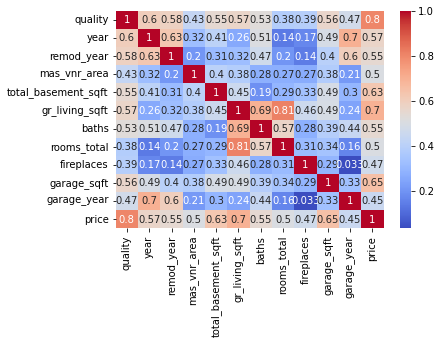

In [47]:
sns.heatmap(data[keepers].corr(), annot=True, cmap='coolwarm')

In [225]:
feats = ['quality', 'year', 'remod_year', 'mas_vnr_area', 'total_basement_sqft', 'gr_living_sqft', 'baths', 'rooms_total', 'fireplaces', 'garage_sqft', 'garage_year', 'price']

In [226]:
X_train, X_test, y_train, y_test = train_test_split(data[feats].drop(columns=['price']), data['price'], random_state=110)

<AxesSubplot:xlabel='year', ylabel='price'>

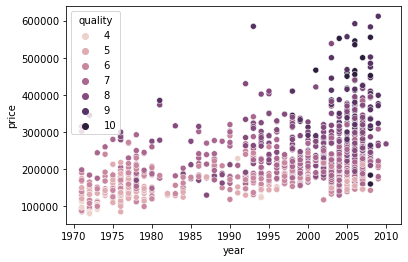

In [249]:
sns.scatterplot(x=data['year'][data['year'] > 1970], y=data['price'][data['year'] > 1970], hue=data['quality'][data['year'] > 1970])

In [227]:
data[feats].head()

,quality,year,remod_year,mas_vnr_area,total_basement_sqft,gr_living_sqft,baths,rooms_total,fireplaces,garage_sqft,garage_year,price
0,6,1976,2005,289.0,725.0,1479,3,6,0,475.0,1976.0,130500
1,7,1996,1997,132.0,913.0,2122,3,8,1,559.0,1997.0,220000
2,5,1953,2007,0.0,1057.0,1057,1,5,0,246.0,1953.0,109000
3,5,2006,2007,0.0,384.0,1444,3,7,0,400.0,2007.0,174000
4,6,1900,1993,0.0,676.0,1445,2,6,0,484.0,1957.0,138500


Make new model for houses built in 2000s

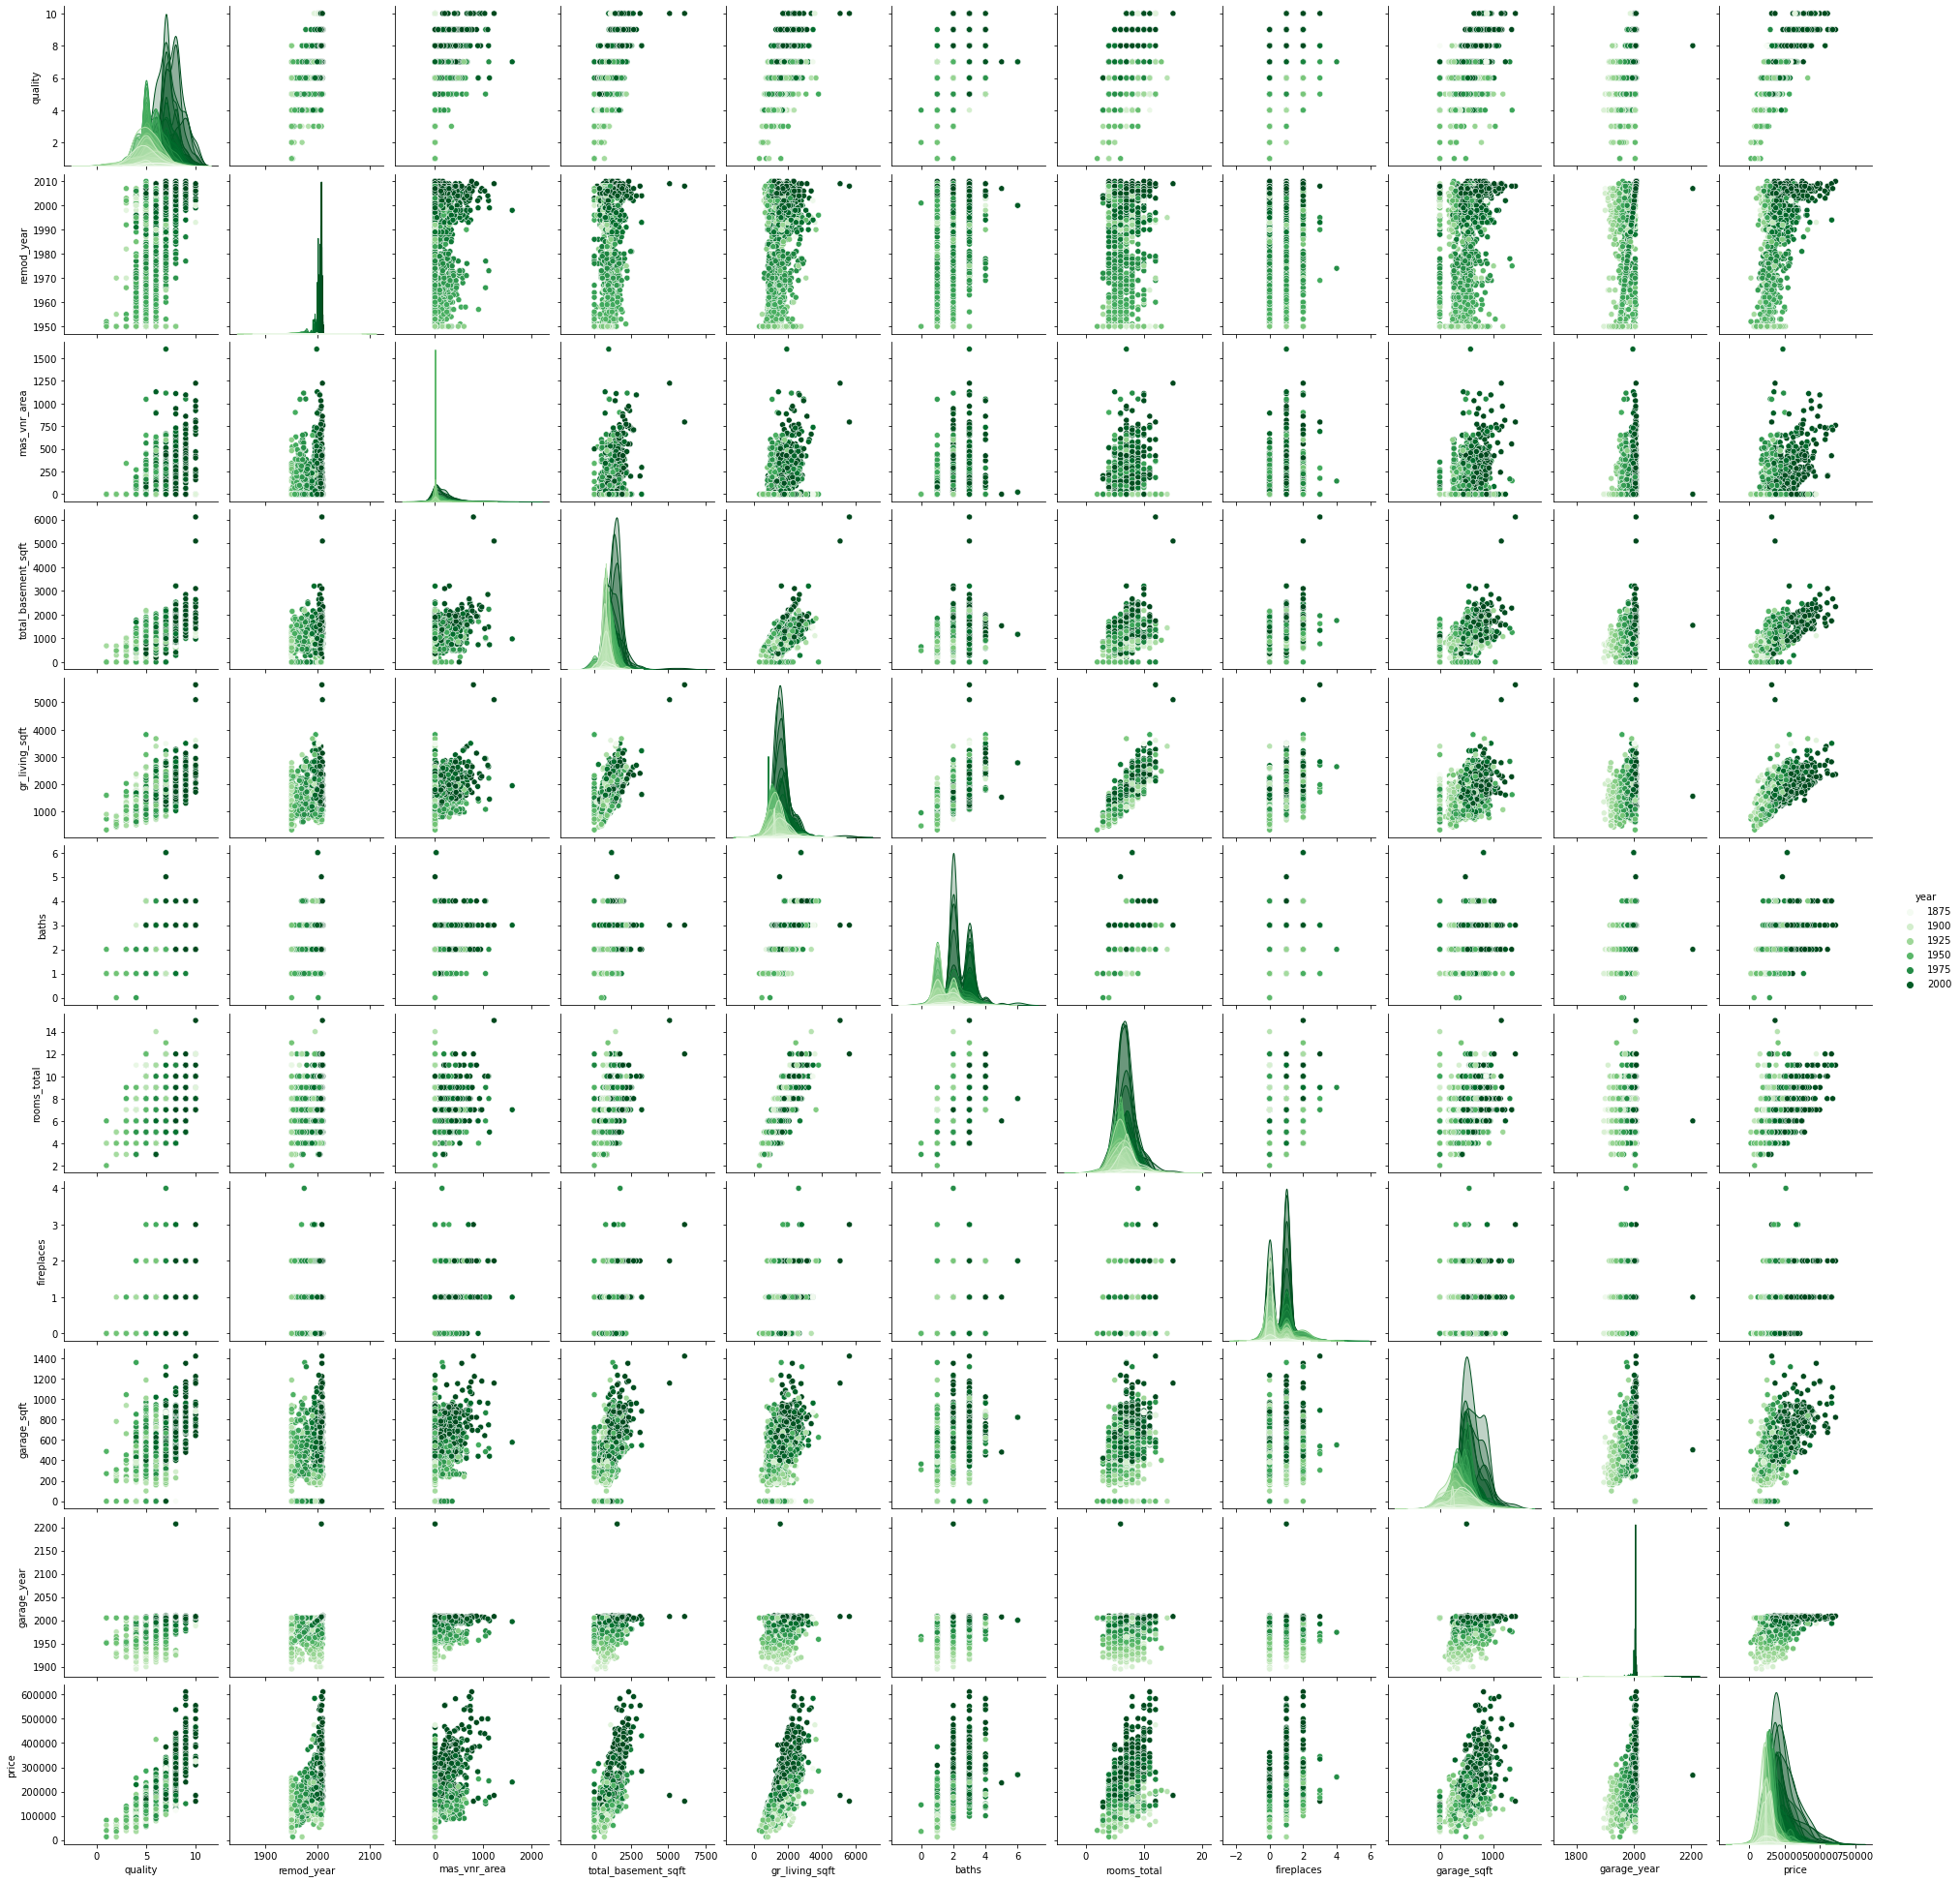

In [237]:
sns.pairplot(data[feats], hue='year', palette='husl');

In [ ]:
ss_tester = StandardScaler()
for c in data[feats]:
    print(max(ss_tester.fit_transform(data[[c]])))
    print(min(ss_tester.fit_transform(data[[c]])))
    data[[c]].hist()
    plt.show()

In [ ]:
data['year'][data['year'] > 1990], y=data['price'][data['year'] > 1970], hue=data['quality'][data['year'] > 1970])

In [228]:
ss = StandardScaler()
lasso = Lasso()
poly = PolynomialFeatures(2)
params = {'lasso__alpha': [.0001, .001, .01, .1, 1, 2, 5]}
# params = {'lasso__alpha': [1, 5, 10, 20, 50, 100, 200, 400, 500, 750, 1000, 1500, 2000]}
piped = make_pipeline(ss, lasso)
gs = GridSearchCV(piped, params)

In [168]:
# X_train_sc = ss.fit_transform(X_train)
# X_test_sc = ss.transform(X_test)

In [229]:
gs.fit(X_train, np.log(y_train))
gs.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01))])

In [212]:
poly_names = PolynomialFeatures(2)
poly_names.fit(data[feats])
pd.DataFrame(data=zip(poly_names.get_feature_names_out(), gs.best_estimator_.named_steps['lasso'].coef_)).sort_values(1)

,0,1
17,quality garage_sqft,-0.028560
37,total_basement_sqft rooms_total,-0.022451
18,quality price,-0.019558
31,remod_year rooms_total,-0.017291
9,price,-0.017214
10,quality^2,-0.016022
41,gr_living_sqft baths,-0.015756
34,total_basement_sqft^2,-0.015249
33,remod_year price,-0.011729
30,remod_year baths,-0.009466


dropped: mas_vnr_area

In [57]:
y_preds = gs.predict(X_test)

print(mean_squared_error(y_train, gs.predict(X_train), squared=False))
print(mean_squared_error(y_test, y_preds, squared=False))
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

37184.20107043425
32226.972578111414
0.7817951452268435
0.8294373545991383


poly features

In [171]:
y_preds = gs.predict(X_test)

print(mean_squared_error(y_train, gs.predict(X_train), squared=False))
print(mean_squared_error(y_test, y_preds, squared=False))
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

28078.573867414474
26510.126438175008
0.8755778816972253
0.8845833399854863


poly no garage

In [180]:
y_preds = gs.predict(X_test)

print(mean_squared_error(y_train, gs.predict(X_train), squared=False))
print(mean_squared_error(y_test, y_preds, squared=False))
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

28078.573867414478
26510.126438175008
0.8755778816972253
0.8845833399854863


#### Log transformed

In [230]:
y_preds = gs.predict(X_test)

print(np.exp(mean_squared_error(np.log(y_train), gs.predict(X_train), squared=False)))
print(np.exp(mean_squared_error(np.log(y_test), y_preds, squared=False)))
print(gs.score(X_train, np.log(y_train)))
print(gs.score(X_test, np.log(y_test)))

1.1876528065742527
1.1841476088137006
0.821994928112104
0.8388376849336593


In [231]:
np.exp(y_preds)

array([138725.80171146, 160318.62776031, 119879.78834699, 127444.63179235,
       177083.34928549, 100865.11798022, 178076.63863387, 228015.44055063,
       185792.97676407, 221099.59302822, 291753.41222396, 174749.71454917,
       260025.92593265, 117842.70771526, 190338.2232954 , 121198.53232679,
       195098.45754673, 174302.08681158, 204206.83284002, 175132.85976628,
       128744.13652573, 159710.68177539, 137426.22365271, 194527.31769058,
       179433.66724567, 202025.00537277, 315995.0288162 , 279420.38980538,
       132272.36658473, 224200.62940304, 193640.54939028, 209349.76758041,
       217084.16618687, 167694.46558426, 126748.9699141 , 179466.82630792,
       267783.09176513, 288929.45498337, 223401.46392426, 143742.17714624,
       226689.0422974 ,  82981.0677024 , 141316.87642751, 101387.7851883 ,
       118136.27635854, 403241.4538253 , 104805.99289555, 231279.68589876,
       295658.37113816, 102586.34332897, 106166.05153957, 126360.10402707,
       105906.83170751, 1

#### Make Predictions for Export

In [181]:
testing = pd.read_csv('./datasets/test.csv')
testing['baths'] = testing['Full Bath'] + testing['Half Bath']
column_dict = {
    'Id': 'id',
    'PID': 'pid',
    'MS SubClass': 'ms_subclass',
    'MS Zoning': 'ms_zoning',
    'Lot Frontage': 'frontage',
    'Lot Area': 'lot_sqft',
    'Street': 'street_material',
    'Alley': 'alley',
    'Lot Shape': 'shape',
    'Land Contour': 'contour',
    'Utilities': 'utilities',
    'Lot Config': 'config',
    'Land Slope': 'slope',
    'Neighborhood': 'neighborhood',
    'Condition 1': 'cond_1',
    'Condition 2': 'cond_2',
    'Bldg Type': 'type',
    'House Style': 'style',
    'Overall Qual': 'quality',
    'Overall Cond': 'condition',
    'Year Built': 'year',
    'Year Remod/Add': 'remod_year',
    'Roof Style': 'roof',
    'Roof Matl': 'roof_mat',
    'Exterior 1st': 'ext_1',
    'Exterior 2nd': 'ext_2',
    'Mas Vnr Type': 'mas_vnr_type',          # what?
    'Mas Vnr Area': 'mas_vnr_area',         # what?
    'Exter Qual': 'exter_qual',
    'Exter Cond': 'exter_cond',
    'Foundation': 'foundation',
    'Bsmt Qual': 'basement_qual',
    'Bsmt Cond': 'basement_cond',
    'Bsmt Exposure': 'basement_exposure',
    'BsmtFin Type 1': 'basement_fin_1',
    'BsmtFin SF 1': 'basement_fin_sqft_1',
    'BsmtFin Type 2': 'basement_fin_2',
    'BsmtFin SF 2': 'basement_fin_sqft_2',
    'Bsmt Unf SF': 'basement_unfin_sqft',
    'Total Bsmt SF': 'total_basement_sqft',
    'Heating': 'heating',
    'Heating QC': 'heating_qc',     # what?
    'Central Air': 'ac',
    'Electrical': 'electrical',
    '1st Flr SF': 'sqft_1',
    '2nd Flr SF': 'sqft_2',
    'Low Qual Fin SF': 'low_qual_sqft',         # what?
    'Gr Liv Area': 'gr_living_sqft',
    'Bsmt Full Bath': 'basement_bath',
    'Bsmt Half Bath': 'basement_half_bath',
    'Full Bath': 'full_bath',
    'Half Bath': 'half_bath',
    'Bedroom AbvGr': 'bed',
    'Kitchen AbvGr': 'kitchen',
    'Kitchen Qual': 'kitchen_qual',
    'TotRms AbvGrd': 'rooms_total',
    'Functional': 'functional',
    'Fireplaces': 'fireplaces',
    'Fireplace Qu': 'fireplace_qual',
    'Garage Type': 'garage_type',
    'Garage Yr Blt': 'garage_year',
    'Garage Finish': 'garage_finish',
    'Garage Cars': 'garage_size',
    'Garage Area': 'garage_sqft',
    'Garage Qual': 'garage_qual',
    'Garage Cond': 'garage_cond',
    'Paved Drive': 'paved_drive',
    'Wood Deck SF': 'deck_wood_sqft',
    'Open Porch SF': 'porch_sqft',
    'Enclosed Porch': 'porch_enc_sqft',
    '3Ssn Porch': 'porch_3_ssn',
    'Screen Porch': 'porch_screened',
    'Pool Area': 'pool_sqft',
    'Pool QC': 'pool_qc',           # what?
    'Fence': 'fence',
    'Misc Feature': 'misc',
    'Misc Val': 'misc_sqft',
    'Mo Sold': 'sold_month',
    'Yr Sold': 'sold_year',
    'Sale Type': 'sale_type',           # what
    'SalePrice': 'price'
}
testing.rename(columns=column_dict, inplace=True)

In [182]:
testing.head()

,id,pid,ms_subclass,ms_zoning,frontage,lot_sqft,street_material,alley,shape,contour,...,porch_screened,pool_sqft,pool_qc,fence,misc,misc_sqft,sold_month,sold_year,sale_type,baths
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,2
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,2
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,9,2006,New,3
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2007,WD,1
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,185,0,NaN,NaN,NaN,0,7,2009,WD,2


In [183]:
feats_clean = [f for f in feats if f != 'price']
testing[feats_clean]

testing[feats_clean].head(2)

,quality,year,remod_year,total_basement_sqft,gr_living_sqft,baths,rooms_total,garage_sqft
0,6,1910,1950,1020,1928,2,9,440
1,5,1977,1977,1967,1967,2,10,580


In [184]:
testing[feats_clean].isna().sum()

quality                0
year                   0
remod_year             0
total_basement_sqft    0
gr_living_sqft         0
baths                  0
rooms_total            0
garage_sqft            0
dtype: int64

In [187]:
output = testing[['id']].rename({'id': 'Id'})
output['SalePrice'] = gs.predict(testing[feats_clean])
output.to_csv('./submissions/simple_2.csv', index=False)
output.head(5)


,id,SalePrice
0,2658,147358.857107
1,2718,159147.392504
2,2414,170690.192599
3,1989,124637.321788
4,625,173006.620106
